In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [3]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-03-26 11:33:16: Data set normalized. Mean value std: 0.00872818475321164


# Training different costs

In [4]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-03-26 11:33:16: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-26 11:33:16: Setting up the training in the target graph ...
[-] 2018-03-26 11:33:16: network ...
[-] 2018-03-26 11:33:16: error function ...
[-] 2018-03-26 11:33:16: cost function ...
[-] 2018-03-26 11:33:31: training step
[-] 2018-03-26 11:33:31: Starting network training ...
[ ] 2018-03-26 11:33:31: Val. Cost: 5.781E-02. Error: 5.780E-02. Diff: 1.0E+10
[ ] 2018-03-26 11:33:32: Val. Cost: 5.391E-05. Error: 5.259E-05. Diff: 5.8E-02
[ ] 2018-03-26 11:33:34: Val. Cost: 2.148E-05. Error: 2.017E-05. Diff: 3.2E-05
[ ] 2018-03-26 11:33:35: Val. Cost: 1.345E-05. Error: 1.214E-05. Diff: 8.0E-06
[ ] 2018-03-26 11:33:36: Val. Cost: 1.202E-05. Error: 1.072E-05. Diff: 1.4E-06
[ ] 2018-03-26 11:33:37: Val. Cost: 1.298E-05. Error: 1.168E-05. Diff: 9.6E-07
[ ] 2018-03-26 11:33:39: Val. Cost: 4.682E-05. Error: 4.549E-05. Diff: 3.4E-05
[ ] 2018-03-26 11:33:40: Val. Cost: 8.875E-06. Error: 7.521E-06

### Check symmetry

0.00132477


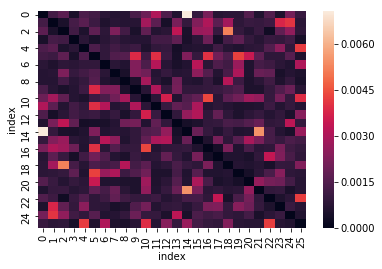

In [16]:
from SCFInitialGuess.utilities.plotutils import matrix_error

with graph_orig.as_default():
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))

plt.show()

### Check idempotency

0.00287641


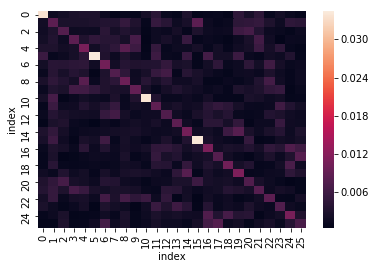

In [17]:
from SCFInitialGuess.utilities.plotutils import matrix_error

def idempotency_error(network):
    p = tf.reshape(network.output_tensor, [-1, dim, dim])
    s_raw = dataset.inverse_input_transform(network.input_tensor)
    s = tf.reshape(s_raw, [-1, dim, dim])
    
    
    lhs = tf.matmul(tf.matmul(p, s), p)
    rhs = 2 * p
    return tf.reduce_mean(tf.abs(lhs - rhs), axis=0)

with graph_orig.as_default():
    
    
    """
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    """
    error = sess_orig.run(
        idempotency_error(network_orig),
       {network_orig.input_tensor: dataset.testing[0]}
    )
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()

## Enforce symmetry

In [7]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.reduce_mean(tf.norm(reshaped - transposed, axis=(1,2))**2 )

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=5e-2)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=1e-6
)
graph_sym = trainer_sym.graph
        

[-] 2018-03-26 11:33:46: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-26 11:33:46: Setting up the training in the target graph ...
[-] 2018-03-26 11:33:46: network ...
[-] 2018-03-26 11:33:46: error function ...
[-] 2018-03-26 11:33:46: cost function ...
[-] 2018-03-26 11:33:46: training step
[-] 2018-03-26 11:33:46: Starting network training ...
[ ] 2018-03-26 11:33:46: Val. Cost: 6.374E-02. Error: 5.815E-02. Diff: 1.0E+10
[ ] 2018-03-26 11:33:48: Val. Cost: 6.298E-04. Error: 2.993E-04. Diff: 5.8E-02
[ ] 2018-03-26 11:33:49: Val. Cost: 2.089E-04. Error: 1.839E-04. Diff: 1.2E-04
[ ] 2018-03-26 11:33:50: Val. Cost: 2.831E-04. Error: 1.442E-04. Diff: 4.0E-05
[ ] 2018-03-26 11:33:52: Val. Cost: 5.086E-04. Error: 3.244E-04. Diff: 1.8E-04
[ ] 2018-03-26 11:33:53: Val. Cost: 1.180E-04. Error: 4.843E-05. Diff: 2.8E-04
[ ] 2018-03-26 11:33:54: Val. Cost: 5.528E-05. Error: 3.149E-05. Diff: 1.7E-05
[ ] 2018-03-26 11:33:56: Val. Cost: 1.604E-04. Error: 1.367E-04

0.000599246


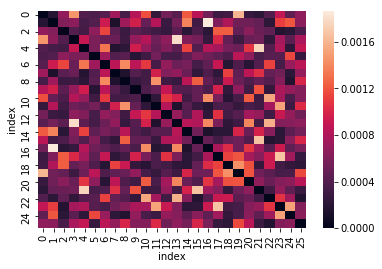

In [18]:
with graph_sym.as_default():
    reshaped = tf.reshape(network_sym.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_sym.run(diff_mean, {network_sym.input_tensor: dataset.testing[0]})
    matrix_error(error)
    print(np.mean(error))

plt.show()

## Enforce idempotency

In [19]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_error(network) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_error(self, network):
        p = tf.reshape(network.output_tensor, [-1, dim, dim])
        s_raw = dataset.inverse_input_transform(network.input_tensor)
        s = tf.reshape(s_raw, [-1, dim, dim])
        

        lhs = tf.matmul(tf.matmul(p, s), p)
        rhs = 2 * p
        return tf.reduce_mean(tf.norm(tf.abs(lhs - rhs), axis=(1,2)) **2 )

try:
    del graph_idem
except:
    pass
    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-5)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=3e-6,
    summary_save_path="log2/idem"
)
graph_idem = trainer.graph

[-] 2018-03-26 11:43:40: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-03-26 11:43:40: Setting up the training in the target graph ...
[-] 2018-03-26 11:43:40: network ...
[-] 2018-03-26 11:43:40: error function ...
[-] 2018-03-26 11:43:40: cost function ...
[-] 2018-03-26 11:43:40: training step
[-] 2018-03-26 11:43:40: Starting network training ...
[ ] 2018-03-26 11:43:40: Val. Cost: 5.779E-02. Error: 5.778E-02. Diff: 1.0E+10
[ ] 2018-03-26 11:43:42: Val. Cost: 6.125E-05. Error: 6.038E-05. Diff: 5.8E-02
[ ] 2018-03-26 11:43:44: Val. Cost: 1.674E-05. Error: 1.648E-05. Diff: 4.4E-05
[ ] 2018-03-26 11:43:46: Val. Cost: 1.063E-05. Error: 1.045E-05. Diff: 6.0E-06
[-] 2018-03-26 11:43:47: Convergence reached after 800 steps.
[-] 2018-03-26 11:43:47: Test error: 1.63769E-05


0.00336399


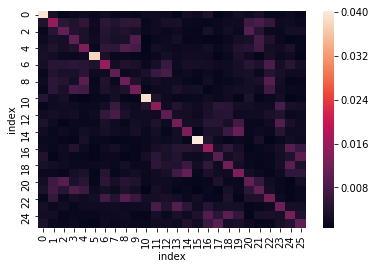

In [20]:
with graph_idem.as_default():
    error = sess_idem.run(idempotency_error(network_idem), {network_idem.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()
    
    

# Analysis

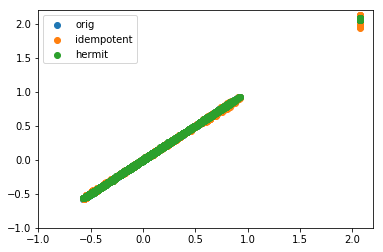

In [21]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

#lower = 1.8
lower = -1
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()
plt.show()

In [22]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.plotutils import prediction_scatter

dim = 26

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))

iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s_raw = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s_raw, mean=dataset.x_mean, std=dataset.x_std)[0]
    
    with graph_orig.as_default():
        P_orig = network_orig.run(sess_orig, s).reshape(dim, dim).astype('float64')
        
        print("idemp orig:    " + str(idemp_error(p, s_raw)))
        print("Idemp orig NN: " + str(idemp_error(P_orig, s_raw)))
        
    with graph_idem.as_default():
        P_idem = network_idem.run(sess_idem, s).reshape(dim, dim).astype('float64')
        print("Idemp idem NN: " + str(idemp_error(P_idem, s_raw)))
    
    with graph_sym.as_default():
        P_sym = network_sym.run(sess_sym, s).reshape(dim, dim).astype('float64')
        print("Idemp sym NN: " + str(idemp_error(P_sym, s_raw)))
    
    
    # P_actual wi noise
    p_noise = p.reshape(dim, dim) + np.random.randn(dim, dim) * 5e-3
    
    
    iterations_molecule = []
    for guess in [p_noise, P_orig, P_idem, P_sym]:
        
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

Warn: Ipython shell catchs sys.args


Calculating: 1/50
idemp orig:    3.75907768904e-16
Idemp orig NN: 0.00280056239815
Idemp idem NN: 0.00695932117641
Idemp sym NN: 0.00226382914004


Warn: Ipython shell catchs sys.args


Calculating: 2/50
idemp orig:    2.62464014762e-16
Idemp orig NN: 0.00273364420007
Idemp idem NN: 0.00515686049982
Idemp sym NN: 0.00132177465382


Warn: Ipython shell catchs sys.args


Calculating: 3/50
idemp orig:    3.37043892472e-16
Idemp orig NN: 0.00604744383056
Idemp idem NN: 0.012096064025
Idemp sym NN: 0.00244666542527


Warn: Ipython shell catchs sys.args


Calculating: 4/50
idemp orig:    3.97763945487e-16
Idemp orig NN: 0.00248145551841
Idemp idem NN: 0.00194634270046
Idemp sym NN: 0.00147699659578


Warn: Ipython shell catchs sys.args


Calculating: 5/50
idemp orig:    3.75384472951e-16
Idemp orig NN: 0.00294408647093
Idemp idem NN: 0.00217675740427
Idemp sym NN: 0.00179266630605


Warn: Ipython shell catchs sys.args


Calculating: 6/50
idemp orig:    2.88822156424e-16
Idemp orig NN: 0.00222151695213
Idemp idem NN: 0.00208172008834
Idemp sym NN: 0.00174944336717


Warn: Ipython shell catchs sys.args


Calculating: 7/50
idemp orig:    3.11886713217e-16
Idemp orig NN: 0.00213341448853
Idemp idem NN: 0.00230703616969
Idemp sym NN: 0.00214985915664


Warn: Ipython shell catchs sys.args


Calculating: 8/50
idemp orig:    3.24045495272e-16
Idemp orig NN: 0.00187847811644
Idemp idem NN: 0.00235248020427
Idemp sym NN: 0.00191587776664


Warn: Ipython shell catchs sys.args


Calculating: 9/50
idemp orig:    2.77582219671e-16
Idemp orig NN: 0.00175965903758
Idemp idem NN: 0.00357004425893
Idemp sym NN: 0.00168143499169


Warn: Ipython shell catchs sys.args


Calculating: 10/50
idemp orig:    3.04285830486e-16
Idemp orig NN: 0.00348441989539
Idemp idem NN: 0.00211948412497
Idemp sym NN: 0.00152790143316


Warn: Ipython shell catchs sys.args


Calculating: 11/50
idemp orig:    3.60298585607e-16
Idemp orig NN: 0.00303434496284
Idemp idem NN: 0.00216083199713
Idemp sym NN: 0.00267285375238


Warn: Ipython shell catchs sys.args


Calculating: 12/50
idemp orig:    2.54253769513e-16
Idemp orig NN: 0.00223709602043
Idemp idem NN: 0.00330468698284
Idemp sym NN: 0.00193741812347


Warn: Ipython shell catchs sys.args


Calculating: 13/50
idemp orig:    4.46323772981e-16
Idemp orig NN: 0.00203882308485
Idemp idem NN: 0.00221803546412
Idemp sym NN: 0.00311783993504


Warn: Ipython shell catchs sys.args


Calculating: 14/50
idemp orig:    2.6252696585e-16
Idemp orig NN: 0.0025472990957
Idemp idem NN: 0.00459355679003
Idemp sym NN: 0.00259513038259


Warn: Ipython shell catchs sys.args


Calculating: 15/50
idemp orig:    3.25480058339e-16
Idemp orig NN: 0.00218609357824
Idemp idem NN: 0.0023148382876
Idemp sym NN: 0.00180058435894


Warn: Ipython shell catchs sys.args


Calculating: 16/50
idemp orig:    3.42486314723e-16
Idemp orig NN: 0.0020120168287
Idemp idem NN: 0.00302793604124
Idemp sym NN: 0.00189120424359


Warn: Ipython shell catchs sys.args


Calculating: 17/50
idemp orig:    2.93756759869e-16
Idemp orig NN: 0.00222881544804
Idemp idem NN: 0.00194739005759
Idemp sym NN: 0.0022249020629


Warn: Ipython shell catchs sys.args


Calculating: 18/50
idemp orig:    3.70587199108e-16
Idemp orig NN: 0.00233977167578
Idemp idem NN: 0.00454969228478
Idemp sym NN: 0.00321051975914


Warn: Ipython shell catchs sys.args


Calculating: 19/50
idemp orig:    3.77464665581e-16
Idemp orig NN: 0.00319984441381
Idemp idem NN: 0.00214557346198
Idemp sym NN: 0.00177783931132


Warn: Ipython shell catchs sys.args


Calculating: 20/50
idemp orig:    3.00717586413e-16
Idemp orig NN: 0.00266045736618
Idemp idem NN: 0.00259524556338
Idemp sym NN: 0.00173680374152


Warn: Ipython shell catchs sys.args


Calculating: 21/50
idemp orig:    3.39089361763e-16
Idemp orig NN: 0.0022362688675
Idemp idem NN: 0.00260413319928
Idemp sym NN: 0.00244129445646


Warn: Ipython shell catchs sys.args


Calculating: 22/50
idemp orig:    3.14664179359e-16
Idemp orig NN: 0.00296769330829
Idemp idem NN: 0.00278393054237
Idemp sym NN: 0.00255472631974


Warn: Ipython shell catchs sys.args


Calculating: 23/50
idemp orig:    3.69363622425e-16
Idemp orig NN: 0.00240232845832
Idemp idem NN: 0.00221854326784
Idemp sym NN: 0.00150990447723


Warn: Ipython shell catchs sys.args


Calculating: 24/50
idemp orig:    2.92387673953e-16
Idemp orig NN: 0.00213104223644
Idemp idem NN: 0.00311759092132
Idemp sym NN: 0.00224805544403


Warn: Ipython shell catchs sys.args


Calculating: 25/50
idemp orig:    3.44322040613e-16
Idemp orig NN: 0.00467856220142
Idemp idem NN: 0.00984820252804
Idemp sym NN: 0.00204116647808


Warn: Ipython shell catchs sys.args


Calculating: 26/50
idemp orig:    2.99071996866e-16
Idemp orig NN: 0.00310350769199
Idemp idem NN: 0.00277294284953
Idemp sym NN: 0.00164696363705


Warn: Ipython shell catchs sys.args


Calculating: 27/50
idemp orig:    3.40260011416e-16
Idemp orig NN: 0.00229065785926
Idemp idem NN: 0.0039459639908
Idemp sym NN: 0.00169064414916


Warn: Ipython shell catchs sys.args


Calculating: 28/50
idemp orig:    2.82759445429e-16
Idemp orig NN: 0.00374899485215
Idemp idem NN: 0.00246766195403
Idemp sym NN: 0.00143266113726


Warn: Ipython shell catchs sys.args


Calculating: 29/50
idemp orig:    3.50997141392e-16
Idemp orig NN: 0.00309306398422
Idemp idem NN: 0.00285996134303
Idemp sym NN: 0.00258075469469


Warn: Ipython shell catchs sys.args


Calculating: 30/50
idemp orig:    3.15171777636e-16
Idemp orig NN: 0.00206778168414
Idemp idem NN: 0.0028082523871
Idemp sym NN: 0.0023350537648


Warn: Ipython shell catchs sys.args


Calculating: 31/50
idemp orig:    3.42403235326e-16
Idemp orig NN: 0.00216189221093
Idemp idem NN: 0.00266606342122
Idemp sym NN: 0.00184655244548


Warn: Ipython shell catchs sys.args


Calculating: 32/50
idemp orig:    3.56398605341e-16
Idemp orig NN: 0.00203649612772
Idemp idem NN: 0.00217886103535
Idemp sym NN: 0.00150102900954


Warn: Ipython shell catchs sys.args


Calculating: 33/50
idemp orig:    3.62122402916e-16
Idemp orig NN: 0.00186603781465
Idemp idem NN: 0.00309941467323
Idemp sym NN: 0.00217001173264


Warn: Ipython shell catchs sys.args


Calculating: 34/50
idemp orig:    3.56856484287e-16
Idemp orig NN: 0.00305158679464
Idemp idem NN: 0.00253344412514
Idemp sym NN: 0.00185942712134


Warn: Ipython shell catchs sys.args


Calculating: 35/50
idemp orig:    3.71433710804e-16
Idemp orig NN: 0.00551863629691
Idemp idem NN: 0.00362016263358
Idemp sym NN: 0.00174212353138


Warn: Ipython shell catchs sys.args


Calculating: 36/50
idemp orig:    3.14295574678e-16
Idemp orig NN: 0.00560956054301
Idemp idem NN: 0.00232316685414
Idemp sym NN: 0.00216517668707


Warn: Ipython shell catchs sys.args


Calculating: 37/50
idemp orig:    3.40814943297e-16
Idemp orig NN: 0.00341112370957
Idemp idem NN: 0.00431933366868
Idemp sym NN: 0.00191106178734


Warn: Ipython shell catchs sys.args


Calculating: 38/50
idemp orig:    3.57171159533e-16
Idemp orig NN: 0.00244699986211
Idemp idem NN: 0.0035170325809
Idemp sym NN: 0.00202753853322


Warn: Ipython shell catchs sys.args


Calculating: 39/50
idemp orig:    3.28613338464e-16
Idemp orig NN: 0.0025165605562
Idemp idem NN: 0.00367904385967
Idemp sym NN: 0.0032558469069


Warn: Ipython shell catchs sys.args


Calculating: 40/50
idemp orig:    3.00502029058e-16
Idemp orig NN: 0.00287065499818
Idemp idem NN: 0.00213312981199
Idemp sym NN: 0.00165471069796


Warn: Ipython shell catchs sys.args


Calculating: 41/50
idemp orig:    2.76759685523e-16
Idemp orig NN: 0.00214809796958
Idemp idem NN: 0.00274655050229
Idemp sym NN: 0.00184130815723


Warn: Ipython shell catchs sys.args


Calculating: 42/50
idemp orig:    3.625175914e-16
Idemp orig NN: 0.00334352216565
Idemp idem NN: 0.00267022595465
Idemp sym NN: 0.00191290117684


Warn: Ipython shell catchs sys.args


Calculating: 43/50
idemp orig:    3.2162376292e-16
Idemp orig NN: 0.00230027555882
Idemp idem NN: 0.00305499632755
Idemp sym NN: 0.00226651599873


Warn: Ipython shell catchs sys.args


Calculating: 44/50
idemp orig:    2.95155116037e-16
Idemp orig NN: 0.0020105313831
Idemp idem NN: 0.00305645958351
Idemp sym NN: 0.00193095531126


Warn: Ipython shell catchs sys.args


Calculating: 45/50
idemp orig:    2.74560086308e-16
Idemp orig NN: 0.00326413193644
Idemp idem NN: 0.0025165701141
Idemp sym NN: 0.00181824314975


Warn: Ipython shell catchs sys.args


Calculating: 46/50
idemp orig:    2.86918627802e-16
Idemp orig NN: 0.00230864994386
Idemp idem NN: 0.0029147570186
Idemp sym NN: 0.00202950528855


Warn: Ipython shell catchs sys.args


Calculating: 47/50
idemp orig:    2.70158161333e-16
Idemp orig NN: 0.00421104754879
Idemp idem NN: 0.00610722012717
Idemp sym NN: 0.00268091204578


Warn: Ipython shell catchs sys.args


Calculating: 48/50
idemp orig:    3.56441247686e-16
Idemp orig NN: 0.00391672067294
Idemp idem NN: 0.00290672534043
Idemp sym NN: 0.00262338917658


Warn: Ipython shell catchs sys.args


Calculating: 49/50
idemp orig:    3.17462896505e-16
Idemp orig NN: 0.00351743811558
Idemp idem NN: 0.00324472051744
Idemp sym NN: 0.00222577460806


Warn: Ipython shell catchs sys.args


Calculating: 50/50
idemp orig:    3.1074389035e-16
Idemp orig NN: 0.00362122713426
Idemp idem NN: 0.00386077821209
Idemp sym NN: 0.00262774366977


In [23]:
print("noise", "orig", "idem", "sym")
print(np.mean(iterations,0))

noise orig idem sym
[ 12.56  13.96  13.78  12.46]


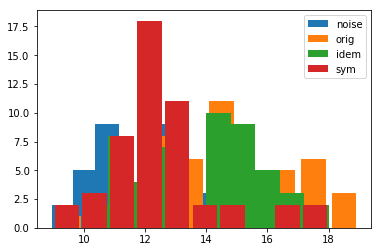

In [25]:

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['noise', 'orig', 'idem', 'sym']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()